In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm
from manada.Sources.sersic import SingleSersicSource
from manada.MainDeflector.simple_deflectors import PEMD
from manada.Sources.cosmos import COSMOSCatalog
from manada.Sources.cosmos_sersic import COSMOSSersic
from manada.PointSource.single_point_source import SinglePointSource
import manada
from manada.Sampling.sampler import Sampler
from manada.Sources.source_base import SourceBase
from lenstronomy.SimulationAPI.data_api import DataAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import matplotlib.pyplot as plt
import os, subprocess, sys
from matplotlib import colors
from astropy.visualization import simple_norm
from fastell4py import _fastell
from manada.generate import draw_image

root_path = manada.__path__[0][:-7]

# Changes to Manada, Fall Quarter 2021

__Author:__ Sydney Erickson with help from Sebastian Wagner-Carena and Ji Won Park

__Goals:__ 

1. Show how Manada operated before Fall 2021 changes
2. Walk through each change and demonstrate its impact

## Before Changes

__Generating a training set using COSMOS galaxies__

Generate a training set using COSMOS galaxies as the source. 

In [ ]:
#Generate COSMOS Training Set

# Change our working directory to the location of generate.py
os.chdir(os.path.join(root_path,'manada'))
config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_COSMOSonly.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/COSMOS_data')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

In [ ]:
#Plot images
# Load the metadata
# Sebastian - this is where I see an error in the metadata.csv
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)
raise ValueError("Sebastian - this is where I get an error in the metadata.csv")

# is this the best way to normalize?
nt=8
norm=simple_norm(np.load(os.path.join(output_path,'image_%07d.npy'%nt)), stretch='asinh', min_cut=1e-4)
f, ax = plt.subplots(3,3,figsize=(6,6),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)

for i in range(0,3) :
    for j in range(0,3) :
        nt = i + j
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].matshow(image, origin='lower', norm=norm, cmap='plasma')

plt.suptitle('COSMOS Only Training Set')
plt.show()

__Generating a training set using a single sersic source__

Note that this is already done in the last section of Understanding_Manada_Pipeline notebook using the SingleSersicSource class. We will repeat the code here so that users can easily compare training sets generated using COSMOSCatalog and SingleSersicSource source classes.

In [ ]:
config_path = os.path.join(root_path,'notebooks/notebook_data/config_example.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/Sersic_data')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

In [ ]:
#Plot images
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'))

nt=8
norm=simple_norm(np.load(os.path.join(output_path,'image_%07d.npy'%nt)), stretch='asinh', min_cut=1e-4)
f, ax = plt.subplots(3,3,figsize=(6,6),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)

for i in range(0,3) :
    for j in range(0,3) :
        nt = i + j
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].matshow(image, origin='lower', norm=norm, cmap='plasma')

plt.suptitle('Sersic Only Training Set')
plt.show()

## After Changes

__Adding a Sersic light source on top of a COSMOS galaxy__

The first step was to make a source class, COSMOSSersic, that is used to generate images with two sources added together: a Sersic Ellipse and a COSMOS galaxy. This isn't intended to be used to represent anything physical, rather it will be used to validate results we get when adding a point source to a COSMOS galaxy. We want to make sure the images from the point source lie on top of the ring from a Sersic. 

In [ ]:
# Let's generate a training set using this new source class

config_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/config_COSMOSSersic.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/F21_notebook/COSMOSSersic_data')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

In [ ]:
#Plot images
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'))

plt.rcParams["figure.figsize"] = (12,12)
#norm=None
nt=8
norm=simple_norm(np.load(os.path.join(output_path,'image_%07d.npy'%nt)), stretch='asinh', min_cut=1e-4)
f, ax = plt.subplots(3,3,figsize=(6,6),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)

for i in range(0,3) :
    for j in range(0,3) :
        nt = i + j
        image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].matshow(image, origin='lower', norm=norm, cmap='plasma')
plt.suptitle('COSMOS + Sersic Training Set')
plt.show()

Define configuration dictionaries for single image generation

In [57]:
numpix = 128
kwargs_numerics = {'supersampling_factor':2}
cosmos_folder = '/mnt/c/Users/idkwh/Desktop/LSST_DESC/COSMOS_23.5_training_sample/'

config_dict = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.3,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': COSMOSSersic,
        'parameters':{
	        'z_source':1.5,
	        'cosmos_folder':cosmos_folder,
	        'max_z':0.05,
            'minimum_size_in_pixels':650,'min_apparent_mag':20,
            'smoothing_sigma':0.08,'random_rotation':False,
	        'min_flux_radius':10.0,
	        'output_ab_zeropoint':25.127,
	        # start w/ mag=20, see if bright enough to see Sersic
	        'mag_sersic':22,
	        'R_sersic':0.1,
            'n_sersic':2.5,
	        'e1_sersic':0,
	        'e2_sersic':0,
	        'center_x_sersic':0.0,
	        'center_y_sersic':0.0}
    },
    'point_source':{
        'class': SinglePointSource,
        'parameters':{
            'x_point_source':0.0,
			'y_point_source':0.0,
			'magnitude':18.75,
			'mag_zeropoint':25.127}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
		'parameters':{
			'psf_type':'GAUSSIAN',
			'fwhm': 0.5
		}
	},
    'detector':{
        'parameters':{'pixel_scale':0.04,'magnitude_zero_point':25,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

# 2nd dict is only used to validate what subtraction should look like w/ SingleSersicSource

config_dict_sersic = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.3,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': SingleSersicSource,
        'parameters':{
	        'z_source':1.5,
	        'amp':70,
	        'R_sersic':0.1,
            'n_sersic':2.5,
	        'e1':0,
	        'e2':0,
	        'center_x':0.0,
	        'center_y':0.0}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
        'parameters':{'psf_type':'NONE'}
    },
    'detector':{
        'parameters':{'pixel_scale':0.04,'magnitude_zero_point':25,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

Generate images to validate COSMOSSersic source class

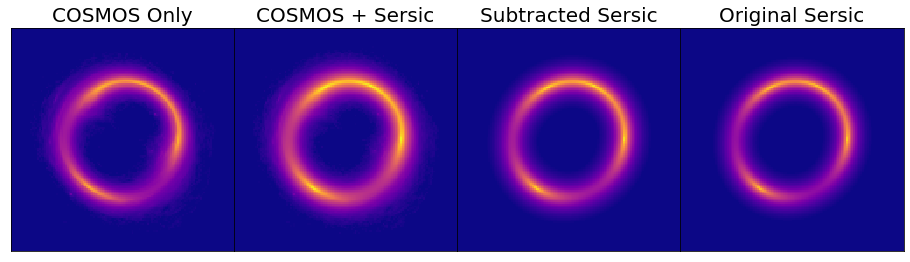

In [41]:
from manada.generate import draw_image

sampler = Sampler(config_dict)
sample = sampler.sample()

main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])
#generates an image no PSF, no noise

# use source_class = COSMOSCatalog
# returns np.array of image & a dict of metadata
source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)

# use source_class = COSMOSSersic
# returns np.array of image & a dict of metadata
source_class = config_dict['source']['class'](
		sample['cosmology_parameters'],sample['source_parameters'])
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)


sampler_s = Sampler(config_dict_sersic)
sample_s = sampler_s.sample()

main_deflector_class = config_dict_sersic['main_deflector']['class'](
			sample_s['main_deflector_parameters'],sample_s['cosmology_parameters'])
source_class = config_dict_sersic['source']['class'](
		sample_s['cosmology_parameters'],sample_s['source_parameters'])
#generates an image no PSF, no noise

# use source_class = COSMOSSersic
# returns np.array of image & a dict of metadata
im_s, metadata_s = draw_image(sample=sample_s,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=False)


plt.rcParams["figure.figsize"] = (12,6)
#norm=None
norm=simple_norm(im2, stretch='log', min_cut=1e-3)
# 3 images: COSMOS, COSMOS+Sersic, COSMOS+Sersic - COSMOS
im3 = im2 - im1

images = [im1, im2, im3, im_s]
titles = ['COSMOS Only', 'COSMOS + Sersic', 'Subtracted Sersic', 'Original Sersic']


f, ax = plt.subplots(1,4,figsize=(16,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,4) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[i], origin='lower', norm=norm, cmap='plasma')
	ax[i].set_title(titles[i], fontsize=20)

plt.show()

__Adding a point source__

Using the same config dicts as above, generate single images to sanity check single point source class

In [42]:
# change R_sersic, n_sersic, mag_sersic, point_source magnitude to generate image
config_dict['source']['parameters']['R_sersic'] = 0.001
config_dict['source']['parameters']['n_sersic'] = 6.5
config_dict['source']['parameters']['mag_sersic'] = 21
config_dict['point_source']['parameters']['magnitude'] = 18.75

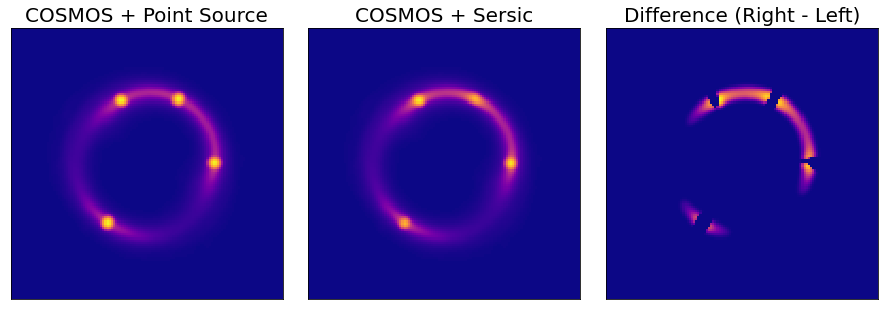

In [43]:
sampler = Sampler(config_dict)
sample = sampler.sample()

main_deflector_class = config_dict['main_deflector']['class'](
			sample['main_deflector_parameters'],sample['cosmology_parameters'])

source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)
	
source_class = COSMOSSersic(sample['cosmology_parameters'],
							sample['source_parameters'])
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=main_deflector_class, source_class=source_class,
		point_source_class=None,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)


#plt.rcParams["figure.figsize"] = (12,6)

images = [im1, im2]
titles = ['COSMOS + Point Source', 'COSMOS + Sersic']
norm=simple_norm(images[0], stretch='log', min_cut=1e-3)

f, ax = plt.subplots(1,3,figsize=(16,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)
for i in range(0,3) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	if i < 2 :
		ax[i].matshow(images[i], origin='lower',norm=norm, cmap='plasma')
		ax[i].set_title(titles[i], fontsize=20)
	else :
		norm=simple_norm(im2-im1, stretch='log', min_cut=1e-5)
		ax[i].matshow(im2-im1, origin='lower', norm=norm, cmap='plasma')
		ax[i].set_title('Difference (Right - Left)', fontsize=20)


plt.show()


Test total flux with no lens to validate the amplitude to magnitude conversion

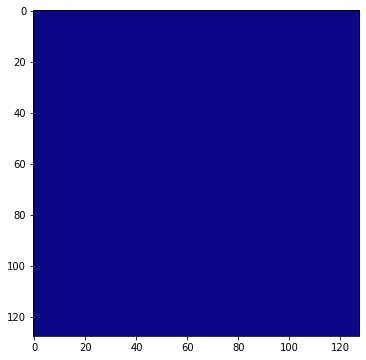

True Flux:  11240.871934697292
Flux from image:  0.0


In [58]:
from lenstronomy.Util.data_util import magnitude2cps

config_dict['point_source']['parameters']['magnitude'] = 15

sampler = Sampler(config_dict)
sample = sampler.sample()

source_class = COSMOSCatalog(sample['cosmology_parameters'],
							sample['source_parameters'])
point_source_class = SinglePointSource(sample['point_source_parameters'])

# COSMOS+PointSource
im1, metadata1 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=None, source_class=source_class,
		point_source_class=point_source_class,
		numpix=numpix,multi_plane=False,kwargs_numerics=kwargs_numerics,
		mag_cut=1.0,add_noise=False, apply_psf=True)
# Just COSMOS
im2, metadata2 = draw_image(sample=sample,los_class=None,subhalo_class=None,
		main_deflector_class=None, source_class=source_class,
		point_source_class=None,numpix=numpix,multi_plane=False,
		kwargs_numerics=kwargs_numerics,mag_cut=1.0,add_noise=False, 
		apply_psf=True)

# Just point source
im_ps = im1-im2
plt.imshow(im_ps, cmap='plasma')
plt.show()


#im1 is a 2d array of surface brightness pixels
flux_true = magnitude2cps(config_dict['point_source']['parameters']['magnitude'], config_dict['point_source']['parameters']['mag_zeropoint'])
flux_image = np.sum(im_ps)

print("True Flux: ", flux_true)
print("Flux from image: ", flux_image)